# Introduction and Background

Jeopardy! is one of the United States' longest running, general knowledge, trivia game shows. The show consists of the host, currently Alex Trebek, reading clues to contestants and the contestants have to guess what question the clue is the answer to. This is why all Jeopardy! answers are phrased in the form of a question.

There have been several contestants who have dominated the game using various tactics. One contestant, Ken Jennings, went on the longest Jeopardy! winning streak in the show's history. It was not just because Jennings had an encyclopedic mind with perfect recall, he also employed certain game theory tactics in order to maximize his daily winnings, which was how the winner was determined. At the end of the game, the player with the highest earnings wins, and moves on to the next day. Another player, Arthur Chu, became popular after going on a short winning streak using an unorthadox strategy with seemingly arbitrary wagers on the Daily Double questions. Chu also noted that there was a pattern: certain answers/clues would be more likely to appear in certain categories. 

The goal of this project is to determine whether or not there is an optimal strategy to preparing to be a contestant on Jeopardy!

This question is of particular interest to one of our group members, Brandon Nguyen, who was a former contestant of another game show and is an avid Jeopardy fan. During his time watching and follow Jeopardy, Brandon has noticed that some of the most successful Jeopardy players had very obvious strategies in order to go on massive winning streaks. After the successes of people such as Jennings and Chu, we would like to see if there is truth in their observations about the game.

Our goal is to find out which subjects a potential Jeopardy! contestant should study in order to maximize his or her performance on the game show. We are interested in whether trends in past Jeopardy! clues, categories, and answers could help guide a contestant's studying. We hypothesize that the frequencies of certain groups of clues, categories, and answers will be significant enough to discern the best subjects to study when preparing for Jeopardy!. In order to test our hypothesis, we will categorize clues and answers by subject and examine the frequency, or number of occurrances of subjects, both over the lifetime of the game-show and by year.

To organize our analysis and discussion, we will define our list of subjects: Arts, Geography, History, Literature, Pop Culture, and Science.

# Data Description  


We will be using data from the Jeopardy Archives, which was consolidated by a Reddit user named trexmatt. Using a data scraper, trexmatt has compiled a CSV file containing over 200,000 observations which include: show numner, show air date, the round a question was asked, clue category, clue monetary value, the clue itself, and the answer (which would be phrased as a question). By analyzing this data, we hope to uncover any underlying patterns hidden away in the clues of the game.

To make our phrasing more intuitive, from now on, the clue will be referred to as the question.

The CSV file contains the question as a whole, and the answer column has the answer to the clue without the leading words that would make the phrasing a question. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

C:\Users\ben\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('JEOPARDY_CSV.csv')

In [3]:
df.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [4]:
df.tail(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 ...,Turandot
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,In North America this term is properly applied...,a titmouse
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,$2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo
216929,4999,2006-05-11,Final Jeopardy!,HISTORIC NAMES,None,A silent movie title includes the last name of...,Grigori Alexandrovich Potemkin


# Data Cleaning and Pre-Processing
Before analyzing the data set, we need to do some data cleaning and pre-processing. Firstly, we decided to drop some of the columns that we will not be using in our analysis. The columns that we dropped are the Show Number and the Question columns. The columns that we cleaned up are the Air Dates, Value, and Answer columns. We did some processing on the Air Date column and extracted the year out of each observation, and in our cleaned up dataframe we renamed the Air Date column to year. For the Value column, we processed the money value by removing the dollar sign and commas, and we converted the type to be an integer. Additionally, we standardized each observation's money value by dividing by 2 for Double Jeopardy! questions. 

The Answer column proved to be the most difficult to clean. For this column, we cleaned each observation by removing quotes, parentheses and leading "a", "an", and "the" when appropriate. After removing those, we stripped the answers of any leading and trailing whitespace. Finally, we converted all the answers to lower case. Because we plan to analyze the uniqueness and frequency the answers, it is important to standardize the answers as best as possible. We cleaned the answers to the best of our ability, but it is not perfect. The messiness of the original answers makes it hard for us to clean the answers. For example, some of the answers with parentheses in them made it hard to tell which answers were the same as others. 

The following are some answers that will illustrate our problem:<br>
Ceylon (or Sri Lanka)<br>
Ceylon

In this case, we thought it would be best to completely remove the parentheses AND the content within them. Then, the answers would both be standardized to Ceylon. 

(Vladimir) Putin<br>
Vladimir Putin<br>

In this case, we only want to remove the parentheses, but keep the content within them. Then both answers would be standardized to Vladimir Putin.

Since the answers are so messy, we could not come up with a set of rules that would clean up and correctly standardize all the answers. In the end, we made the decision to only remove the parentheses. This helps in many cases, but it is not perfect.

In [5]:
# This method will be used to do some cleaning on the data: removing punctuation, parentheticals, leading articles,
# standardzing the letter case of the answers

def cleanAnswer(answer):
    answer = answer.replace('"', "")
    answer = answer.replace('(', "")
    answer = answer.replace(')', "")
    split = answer.split(' ', 1)
    firstWord = split[0]
    if len(split) == 2 and (firstWord == 'an' or firstWord == 'a' or firstWord == 'the'):
        answer = split[1]
    
    answer.strip()
    answer = answer.lower()
    return answer

In [6]:
# test clean method
print(cleanAnswer(' HELLO '), cleanAnswer('"A Streetcar Named Desire"'), cleanAnswer('the'), cleanAnswer('(Vladimir) Putin'))

 hello  a streetcar named desire the vladimir putin


In [7]:
# This method will take out the month/day of the show's air date. This helps us remove some of the privacy concerns
# as well as makes the data easier to work with

def cleanDate(date):
    return date[:4]

In [8]:
# This method will convert the monetary value of each question into an int type and remove leading dollar signs and
# any commas in the number

def convertValues(cost):
    if cost == "None":
        return 0
    cost = cost.replace("$", '')
    cost = cost.replace(',','')
    cost = int(cost)
    return cost

In [9]:
# This cell will apply the cleaning methods and then create a new dataframe with the cleaned data.

dfClean = pd.DataFrame()
#dfClean.columns = ['Year', 'Round', 'Category', 'Value', 'Answer']
dfClean['year'] = df[' Air Date'].apply(cleanDate)
dfClean['category'] = df[' Category']
dfClean['answer'] = df[' Answer'].apply(cleanAnswer)
dfClean = dfClean[dfClean['year'] != '2012']
display(dfClean)
dfClean.to_csv('jeopardyDFClean.csv')

,year,category,answer
0,2004,HISTORY,copernicus
1,2004,ESPN's TOP 10 ALL-TIME ATHLETES,jim thorpe
2,2004,EVERYBODY TALKS ABOUT IT...,arizona
3,2004,THE COMPANY LINE,mcdonald's
4,2004,EPITAPHS & TRIBUTES,john adams
5,2004,3-LETTER WORDS,ant
6,2004,HISTORY,appian way
7,2004,ESPN's TOP 10 ALL-TIME ATHLETES,michael jordan
8,2004,EVERYBODY TALKS ABOUT IT...,washington
9,2004,THE COMPANY LINE,crate & barrel


# Data Visualization

In order to put our hypothesis to the test, we want to find out which categories and answers are the most common, as those would be good subjects to study in prepartion of competing on Jeopardy!. 

To get a sense of how the most common answers and categories vary (or not) in frequency over time, we will create two heat maps. The first will be a graph with answers on the y axis and year on the x axis. The second will be a graph with categories on the y axis and year on the x axis. Both graphs will be colored based on how many times the answer or category appeared in a given year.

In [10]:
observationsByYear = dfClean['year'].value_counts()

In [11]:
minYear = int(dfClean['year'].min())
maxYear = int(dfClean['year'].max())

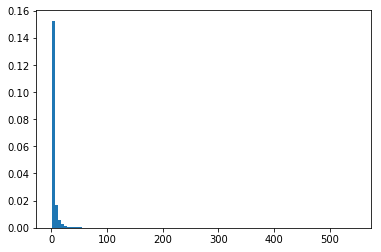

In [12]:
# Figure 1
# A histogram showing the percantage of the total number of categories that have a certain number of questions

allCatCounts = dfClean['category'].value_counts()
fig1 = plt.gcf()
plt.hist(allCatCounts, normed=True, bins=100)
plt.show()

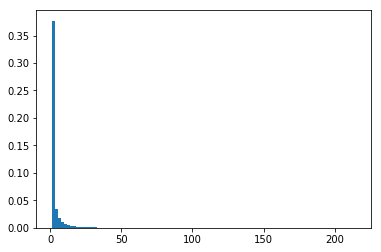

In [13]:
# Figure 2

allAnswerCounts = dfClean['answer'].value_counts()
fig2 = plt.gcf()
plt.hist(allAnswerCounts, normed=True, bins=100)
plt.show()

In [14]:
catTop = dfClean['category'].value_counts()[:50]

In [15]:
cats = []

for year in range(minYear, maxYear+1):
    yearCats = dfClean[dfClean['year']==str(year)]
    countsInYear = []
    for i in range(0, len(catTop)):
        cat = yearCats[yearCats['category']==catTop.index[i]]
        countsInYear.append(len(cat)/float(observationsByYear[str(year)]))
    
    cats.append(countsInYear)
    
cats = np.transpose(cats)

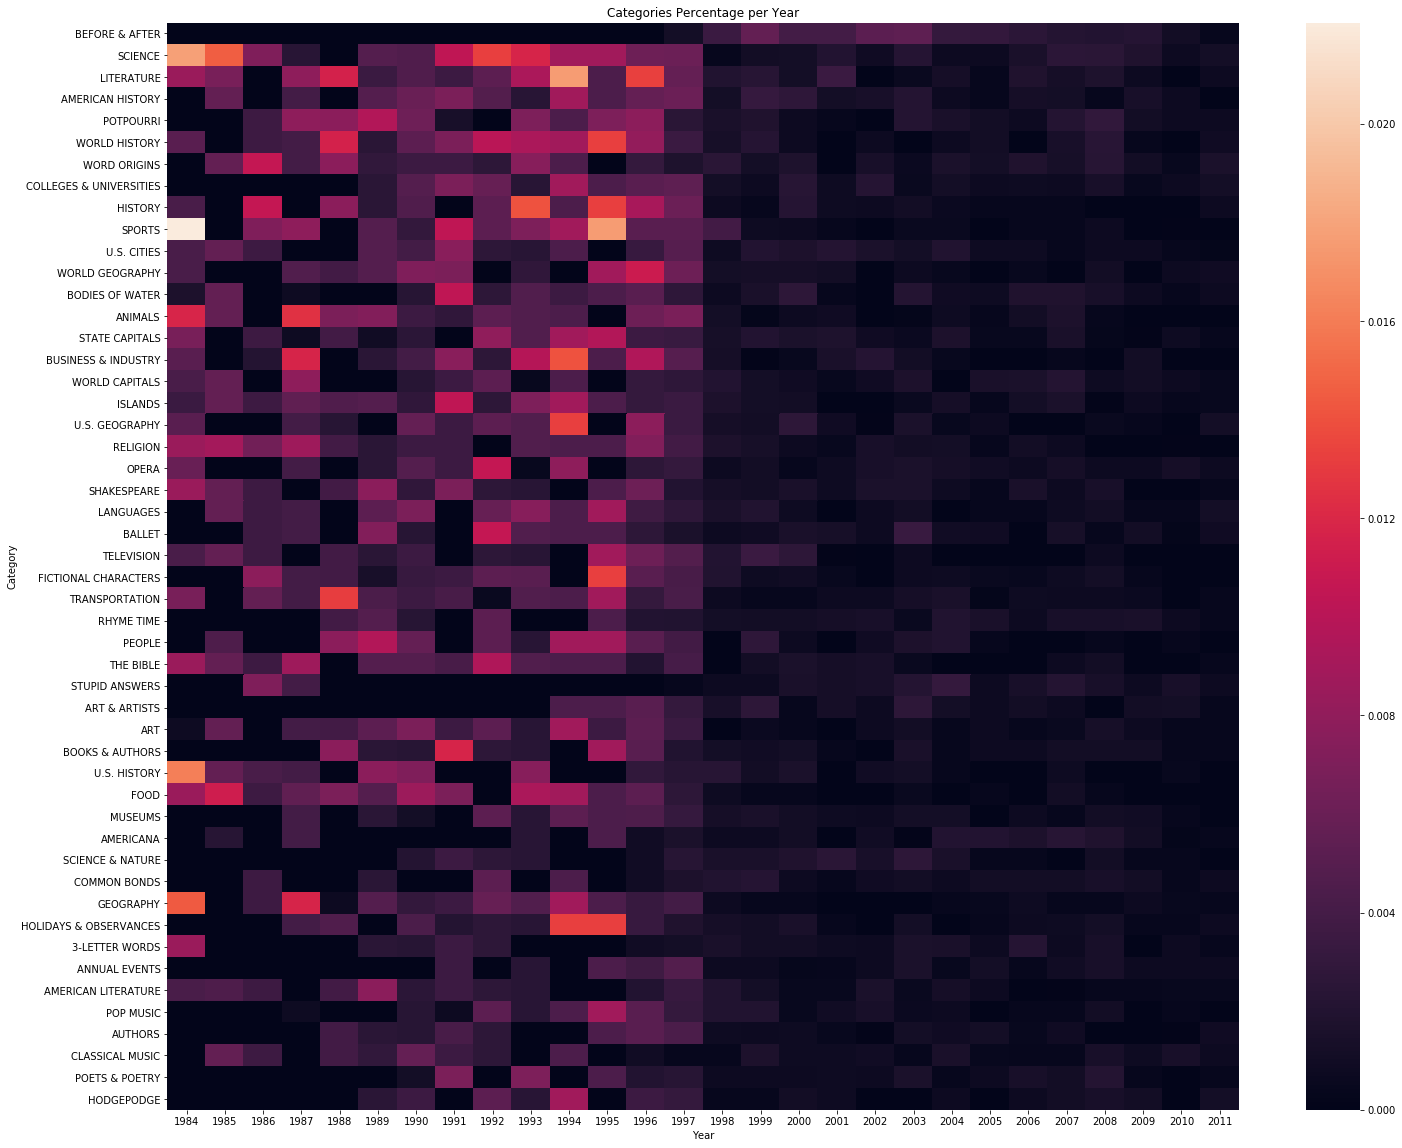

In [16]:
plt.figure(figsize=(24,20))
catsHeat = sns.heatmap(cats, annot=False, fmt="d")

catsHeat.set_xticklabels(range(minYear, maxYear + 1))
catsHeat.set_yticklabels(catTop.index, rotation=0)
catsHeat.set_xlabel('Year')
catsHeat.set_ylabel('Category')
catsHeat.set_title('Categories Percentage per Year')
plt.show()

In [17]:
answerTop = dfClean['answer'].value_counts()[:50]

In [18]:
answers = []

for year in range(minYear, maxYear + 1):
    yearAnswers = dfClean[dfClean['year']==str(year)]
    answerCountsInYear = []
    for i in range(0, len(answerTop)):
        answer = yearAnswers[yearAnswers['answer']==answerTop.index[i]]
        answerCountsInYear.append(len(answer)/observationsByYear[str(year)])
    
    answers.append(answerCountsInYear)
    
answers = np.transpose(answers)

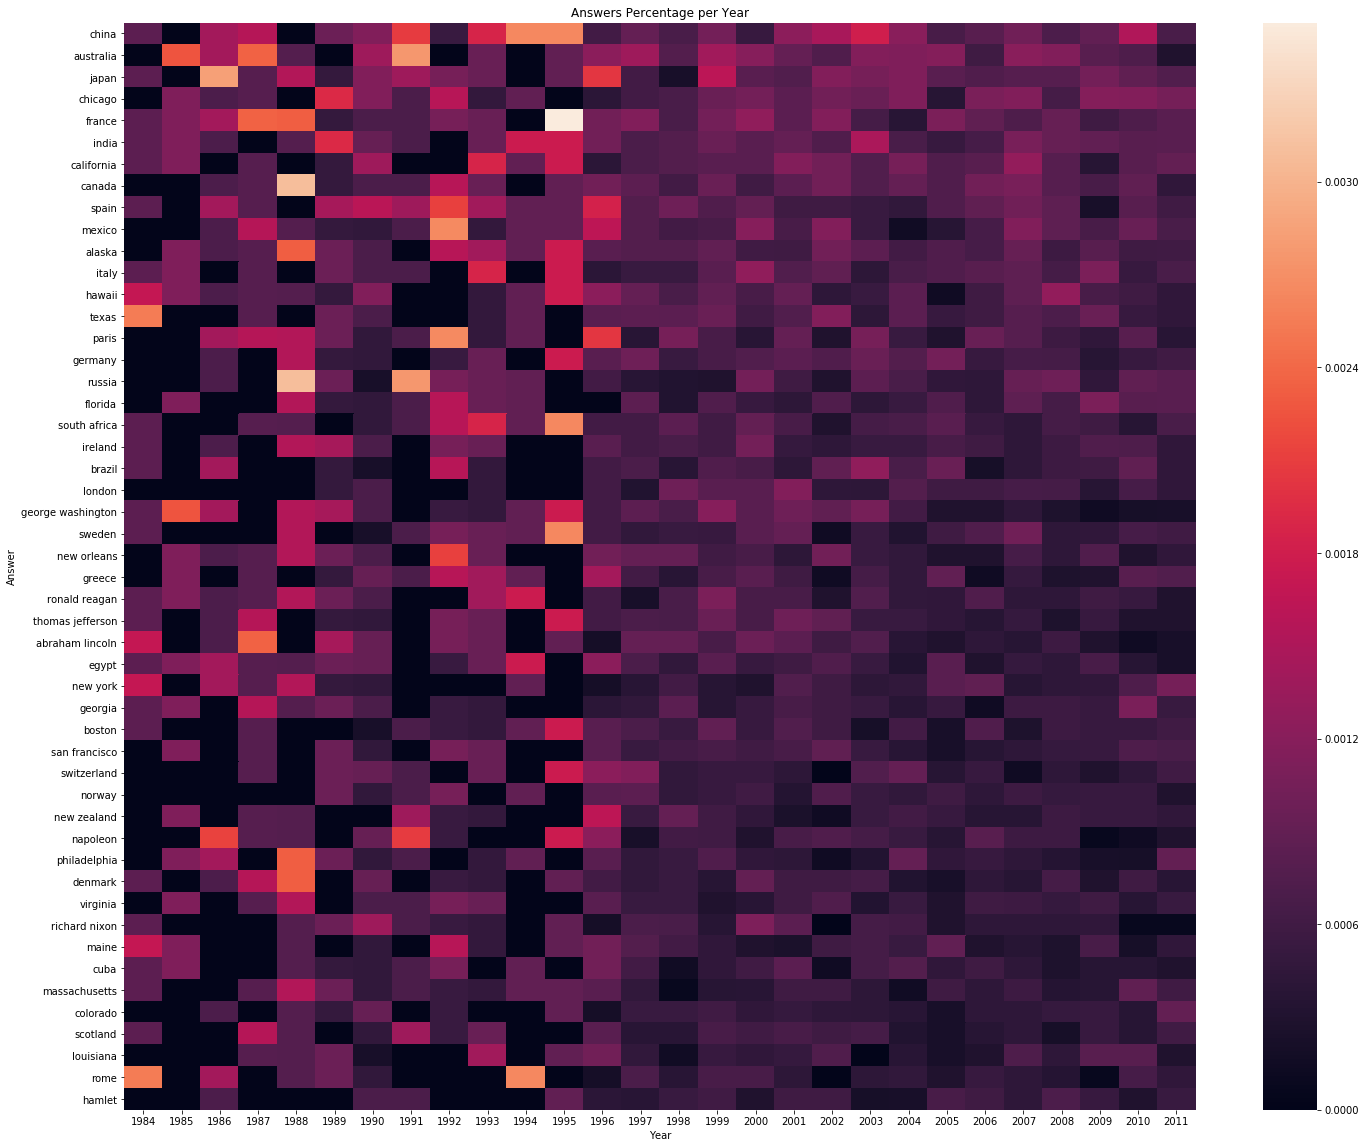

In [19]:
plt.figure(figsize=(24,20))
answersHeat = sns.heatmap(answers, annot=False, fmt="d")

answersHeat.set_xticklabels(range(minYear, maxYear + 1))
answersHeat.set_yticklabels(answerTop.index, rotation=0)
answersHeat.set_xlabel('Year')
answersHeat.set_ylabel('Answer')
answersHeat.set_title('Answers Percentage per Year')
plt.show()

# Data Analysis and Results

## Assigning Subjects to Categories

In [20]:
subjectList = ['Arts', 'History', 'Geography', 'Literature', 'Pop Culture', 'Science']

In [21]:
topCategories = dfClean['category'].value_counts()

In [22]:
categoriesWithSubject = topCategories[:50]
display(categoriesWithSubject)

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           412
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    346
HISTORY                    344
SPORTS                     342
U.S. CITIES                339
WORLD GEOGRAPHY            338
BODIES OF WATER            327
ANIMALS                    324
STATE CAPITALS             314
BUSINESS & INDUSTRY        311
WORLD CAPITALS             300
ISLANDS                    300
U.S. GEOGRAPHY             299
RELIGION                   297
OPERA                      294
SHAKESPEARE                294
LANGUAGES                  284
BALLET                     282
TELEVISION                 281
FICTIONAL CHARACTERS       280
TRANSPORTATION             279
RHYME TIME                 279
PEOPLE                     279
THE BIBLE                  267
STUPID ANSWERS             265
ART & ARTISTS              265
ART     

We will manually assign a subject label to the top 50 categories. While going through the list of categories above, we found a few categories that we did not know how to label. These categories are BEFORE & AFTER, POTPOURRI, STUPID ANSWERS, and COMMON BONDS. We will drop these categories and fill in our list until we get 50 categories that we are able to label.

In [23]:
categoriesWithSubject = categoriesWithSubject.drop(['BEFORE & AFTER', 'POTPOURRI', 'STUPID ANSWERS', 'COMMON BONDS', 'HODGEPODGE'])

In [24]:
topCategories[50:55]

QUOTATIONS      221
MYTHOLOGY       221
NONFICTION      220
THE MOVIES      218
WORLD CITIES    214
Name: category, dtype: int64

We will take the next 5 categories after HODGEPODGE (QUOTATIONS, MYTHOLOGY, NONFICTION, THE MOVIES, AND WORLD CITIES), since we know suitable labels for them.

In [25]:
categories = categoriesWithSubject.append(topCategories[50:55]).index.tolist()
display(categories)

['SCIENCE',
 'LITERATURE',
 'AMERICAN HISTORY',
 'WORLD HISTORY',
 'WORD ORIGINS',
 'COLLEGES & UNIVERSITIES',
 'HISTORY',
 'SPORTS',
 'U.S. CITIES',
 'WORLD GEOGRAPHY',
 'BODIES OF WATER',
 'ANIMALS',
 'STATE CAPITALS',
 'BUSINESS & INDUSTRY',
 'WORLD CAPITALS',
 'ISLANDS',
 'U.S. GEOGRAPHY',
 'RELIGION',
 'OPERA',
 'SHAKESPEARE',
 'LANGUAGES',
 'BALLET',
 'TELEVISION',
 'FICTIONAL CHARACTERS',
 'TRANSPORTATION',
 'RHYME TIME',
 'PEOPLE',
 'THE BIBLE',
 'ART & ARTISTS',
 'ART',
 'BOOKS & AUTHORS',
 'U.S. HISTORY',
 'FOOD',
 'MUSEUMS',
 'AMERICANA',
 'SCIENCE & NATURE',
 'GEOGRAPHY',
 'HOLIDAYS & OBSERVANCES',
 '3-LETTER WORDS',
 'ANNUAL EVENTS',
 'AMERICAN LITERATURE',
 'POP MUSIC',
 'AUTHORS',
 'CLASSICAL MUSIC',
 'POETS & POETRY',
 'QUOTATIONS',
 'MYTHOLOGY',
 'NONFICTION',
 'THE MOVIES',
 'WORLD CITIES']

In [26]:
subjects = [
    'Science',
    'Literature',
    'History',
    'History',
    'History',
    'Geography',
    'History',
    'Pop Culture',
    'Geography',
    'Geography',
    'Geography',
    'Science',
    'Geography',
    'History',
    'Geography',
    'Geography',
    'Geography',
    'History',
    'Literature',
    'Arts',
    'Literature',
    'Arts',
    'Pop Culture',
    'Pop Culture',
    'History',
    'Literature',
    'Science',
    'History',
    'Arts',
    'Arts',
    'Literature',
    'History',
    'Pop Culture',
    'History',
    'Pop Culture',
    'Science',
    'History',
    'Geography',
    'Literature',
    'History',
    'Literature',
    'Literature',
    'Arts',
    'Arts',
    'Literature',
    'History',
    'History',
    'Literature',
    'Pop Culture',
    'Geography'
]

for sub in subjects:
    assert sub in subjectList
    
catsToSubject = dict(zip(categories, subjects))

In [27]:
def assignSubject(category):
    return catsToSubject[category]

In [28]:
pd.options.mode.chained_assignment = None  # default='warn'
dfCatsAndSubjects = dfClean[dfClean['category'].isin(list(catsToSubject.keys()))]
dfCatsAndSubjects['subject'] = dfCatsAndSubjects['category'].apply(assignSubject)
display(dfCatsAndSubjects.sample(10))

,year,category,answer,subject
132610,1997,ANIMALS,zebra,Science
173481,1990,FOOD,english/burpless/seedless,Pop Culture
93968,1996,WORD ORIGINS,paul langerhans,History
119847,1999,BOOKS & AUTHORS,isaac asimov,Literature
142201,2003,WORLD CAPITALS,"1 of 3 guatemala city, mexico city or panama ...",Geography
100633,2009,BUSINESS & INDUSTRY,american express,History
192644,2000,PEOPLE,frank lloyd wright,Science
102747,2010,3-LETTER WORDS,rye/wry,Literature
159160,2001,BUSINESS & INDUSTRY,kmart,History
64735,1995,LANGUAGES,greek,Literature


In [29]:
subjectCounts = dfCatsAndSubjects['subject'].value_counts()
display(subjectCounts)

History        4073
Geography      3019
Literature     2759
Pop Culture    1611
Arts           1559
Science        1366
Name: subject, dtype: int64

In [30]:
subjectObservationsByYear = {}
for year in range(minYear, maxYear + 1):
    count = len(dfCatsAndSubjects[dfCatsAndSubjects['year']==str(year)])
    subjectObservationsByYear.update({str(year) : count})

In [31]:
subjectsByYear = []
dfSubjectsByYear = pd.DataFrame()
dfSubjectsByYear['year'] = range(minYear, maxYear + 1)

for i in range(0, len(subjectList)):
    subject = dfCatsAndSubjects[dfCatsAndSubjects['subject']==subjectList[i]]
    countsForSubject = []
    for year in range(minYear, maxYear+1):
        yearSubject = subject[subject['year']==str(year)]
        countsForSubject.append(float(len(yearSubject))/float(subjectObservationsByYear[str(year)]))

    subjectsByYear.append(countsForSubject)
    dfSubjectsByYear[subjectList[i]] = countsForSubject
    
display(dfSubjectsByYear)

,year,Arts,History,Geography,Literature,Pop Culture,Science
0,1984,0.046809,0.344681,0.148936,0.136170,0.174468,0.148936
1,1985,0.122951,0.270492,0.163934,0.122951,0.139344,0.180328
2,1986,0.092593,0.438272,0.154321,0.061728,0.191358,0.061728
3,1987,0.049020,0.426471,0.171569,0.102941,0.156863,0.093137
4,1988,0.106383,0.308511,0.191489,0.186170,0.106383,0.101064
5,1989,0.168254,0.273016,0.120635,0.203175,0.092063,0.142857
6,1990,0.114625,0.284585,0.231884,0.173913,0.104084,0.090909
7,1991,0.092857,0.225000,0.282143,0.207143,0.107143,0.085714
8,1992,0.118421,0.244737,0.213158,0.213158,0.078947,0.131579
9,1993,0.045558,0.382688,0.152620,0.177677,0.138952,0.102506


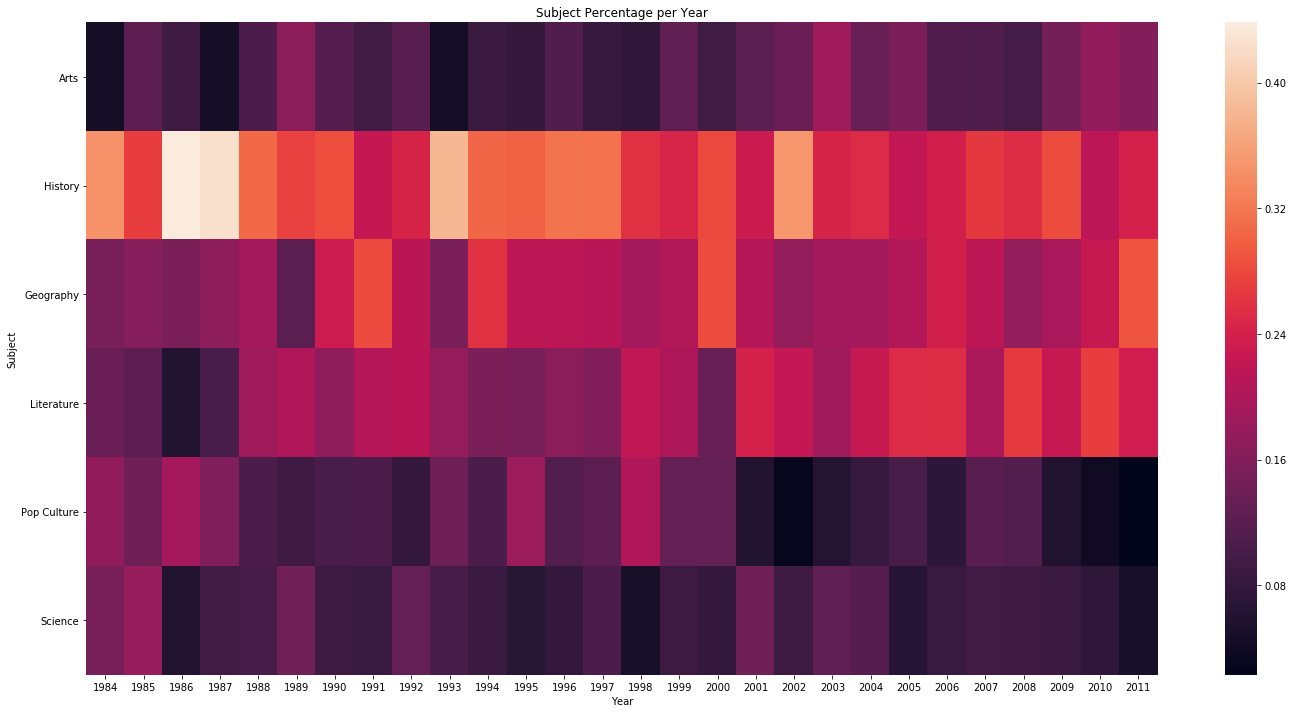

In [32]:
plt.figure(figsize=(24,12))
subjectsHeat = sns.heatmap(subjectsByYear, annot=False, fmt="f")

subjectsHeat.set_xticklabels(range(minYear, maxYear+1))
subjectsHeat.set_yticklabels(subjectList, rotation=0)
subjectsHeat.set_xlabel('Year')
subjectsHeat.set_ylabel('Subject')
subjectsHeat.set_title('Subject Percentage per Year')
plt.show()

## Rising Subjects

In [33]:
geographyIndex = subjectList.index('Geography')
print("Percentage of Geography questions in each year for the last 5 years")
geographyLastFiveYears = subjectsByYear[geographyIndex][-5:]
for i in range(0, len(geographyLastFiveYears)):
    print(str(2007+i) + ': ' + ('%.2f' % (geographyLastFiveYears[i]*100)) + '%')


Percentage of Geography questions in each year for the last 5 years
2007: 21.65%
2008: 17.66%
2009: 19.55%
2010: 22.59%
2011: 29.04%


In [34]:
def riseFactor(lastFiveYears):
    assert len(lastFiveYears) == 5
    sumWeightedDifferences = 0.0
    for i in range(4,0,-1):
        sumWeightedDifferences += (i * 0.1) * (lastFiveYears[i]-lastFiveYears[i-1])
        
    return sumWeightedDifferences

In [35]:
results = []
for i in range(0, len(subjectsByYear)):
    subjectPercentByYear = subjectsByYear[i]
    lastFiveYears = subjectPercentByYear[-5:]
    subjectRiseFactor = (subjectList[i], riseFactor(lastFiveYears))
    results.append(subjectRiseFactor)
    
results.sort(key=lambda tup: tup[1], reverse=True)

for result in results:
    print(result[0] + " rise factor: " + str(result[1]))

Geography rise factor: 0.034723377620948265
Arts rise factor: 0.011910926300661324
Literature rise factor: -0.0024284073736445307
History rise factor: -0.005470595917921688
Science rise factor: -0.015106493848601207
Pop Culture rise factor: -0.02362880678144216


## Consistent Subjects

In [36]:
historyIndex = subjectList.index('History')
years = [1984, 1989, 1994, 1999, 2004, 2009]
print("Percentage of History questions in different years")
geographyLastFiveYears = subjectsByYear[historyIndex]
for i in range(0, len(years)):
    print(str(years[i]) + ': ' + ('%.2f' % (geographyLastFiveYears[years[i]-minYear]*100)) + '%')


Percentage of History questions in different years
1984: 34.47%
1989: 27.30%
1994: 30.53%
1999: 24.58%
2004: 25.22%
2009: 28.33%


In [37]:
def consistentFactor(means, subjectIndex):
    consistency = 0.0
    subjectPercentages = subjectsByYear[subjectIndex]
    for i in range(0, len(means)):
        consistency += (subjectPercentages[i]-means[i])
    return consistency

In [38]:
consistencies = []
means = np.array(subjectsByYear).mean(axis = 0)
for i in range(0, len(subjectList)):
    consistency = (subjectList[i], consistentFactor(means, i))
    consistencies.append(consistency)
    
consistencies.sort(key=lambda tup: tup[1], reverse=True)

for consistency in consistencies:
    print(consistency[0] + " consistent performance factor: " + str(consistency[1]))

History consistent performance factor: 3.3487607613
Geography consistent performance factor: 1.06544510337
Literature consistent performance factor: 0.687743046812
Arts consistent performance factor: -1.52372798395
Pop Culture consistent performance factor: -1.62802701629
Science consistent performance factor: -1.95019391124


## Subject Percentage Prediction
Now we will use linear regression to fit a model to our data.

In [39]:
dfSubjectsByYear.head()

,year,Arts,History,Geography,Literature,Pop Culture,Science
0,1984,0.046809,0.344681,0.148936,0.136170,0.174468,0.148936
1,1985,0.122951,0.270492,0.163934,0.122951,0.139344,0.180328
2,1986,0.092593,0.438272,0.154321,0.061728,0.191358,0.061728
3,1987,0.049020,0.426471,0.171569,0.102941,0.156863,0.093137
4,1988,0.106383,0.308511,0.191489,0.186170,0.106383,0.101064


In [40]:
subjectModels = {}
for subject in subjectList:
    subjectModels[subject] = np.polyfit(dfSubjectsByYear['year'], dfSubjectsByYear[subject], 1)
    
subjectModels

{'Arts': array([  2.38932119e-03,  -4.66042128e+00]),
 'Geography': array([  1.97315827e-03,  -3.73666537e+00]),
 'History': array([ -3.98718386e-03,   8.25066502e+00]),
 'Literature': array([  4.62421337e-03,  -9.04563728e+00]),
 'Pop Culture': array([ -3.45107509e-03,   7.00204533e+00]),
 'Science': array([ -1.54843389e-03,   3.19001358e+00])}

In [41]:
def predictPercentage(subject, year):
    a0 = subjectModels[subject][0]
    a1 = subjectModels[subject][1]
    predictedPercentage = (a0 * year) + a1
    return predictedPercentage

We will now use our linear models to predict the percentages of each subject for the next 5 years.

In [42]:
nextFiveYears = range(maxYear + 1, maxYear + 1 + 5)
for subject in subjectList:
    print("Predictions for Subject: " + subject)
    for year in nextFiveYears:
        print(str(year) + ":\t" + str(predictPercentage(subject, year)*100) + "%")
        
    print()

Predictions for Subject: Arts
2012:	14.6892967421%
2013:	14.9282288616%
2014:	15.1671609811%
2015:	15.4060931006%
2016:	15.64502522%

Predictions for Subject: History
2012:	22.8451099322%
2013:	22.4463915462%
2014:	22.0476731603%
2015:	21.6489547743%
2016:	21.2502363884%

Predictions for Subject: Geography
2012:	23.3329072451%
2013:	23.5302230724%
2014:	23.7275388996%
2015:	23.9248547269%
2016:	24.1221705541%

Predictions for Subject: Literature
2012:	25.8280012158%
2013:	26.2904225524%
2014:	26.7528438891%
2015:	27.2152652258%
2016:	27.6776865625%

Predictions for Subject: Pop Culture
2012:	5.84822559115%
2013:	5.50311808257%
2014:	5.15801057398%
2015:	4.8129030654%
2016:	4.46779555682%

Predictions for Subject: Science
2012:	7.45645927366%
2013:	7.30161588479%
2014:	7.14677249592%
2015:	6.99192910705%
2016:	6.83708571818%



## Answer Analysis

In [43]:
answerTypes = ['literature', 'person', 'place']

In [44]:
answerTop

china                215
australia            214
japan                196
chicago              196
france               191
india                184
california           180
canada               175
spain                171
mexico               163
alaska               161
italy                160
hawaii               157
texas                152
paris                149
germany              147
russia               141
florida              140
south africa         139
ireland              135
brazil               133
london               132
george washington    130
sweden               129
new orleans          128
greece               125
ronald reagan        125
thomas jefferson     123
abraham lincoln      123
egypt                122
new york             121
georgia              119
boston               118
san francisco        117
switzerland          115
norway               111
new zealand          110
napoleon             109
philadelphia         109
denmark              108


In [45]:
classifications = [
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'person',
    'place',
    'place',
    'place',
    'person',
    'person',
    'person',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'person',
    'place',
    'place',
    'place',
    'person',
    'place',
    'place',
    'place',
    'place',
    'place',
    'place',
    'literature'
]

for answerType in classifications:
    assert answerType in answerTypes
    
answerToType = dict(zip(answerTop.index, classifications))

In [46]:
def assignAnswerType(answer):
    return answerToType[answer]

pd.options.mode.chained_assignment = None  # default='warn'
dfAnswerAndType = dfClean[dfClean['answer'].isin(list(answerToType.keys()))]
dfAnswerAndType['type'] = dfAnswerAndType['answer'].apply(assignAnswerType)
display(dfAnswerAndType.sample(10))

,year,category,answer,type
68134,2005,WORLD OF DANCE,greece,place
112830,2003,"WHERE YA FROM, SENATOR?",california,place
163264,2007,IF AT FIRST YOU DON'T SUCCEED...,george washington,person
79463,2003,CONQUERORS,india,place
59919,1997,HISTORIC HOMES,louisiana,place
74769,1996,THE 1750s,george washington,person
190712,2003,PARDON MY FRENCHMAN,napoleon,place
114143,2000,THE AGE OF ENLIGHTENMENT,thomas jefferson,person
61486,2006,SHAKESPEARE,paris,place
104451,2011,STATE QUARTERS,louisiana,place


In [47]:
answerObservationsByYear = {}
for year in range(minYear, maxYear + 1):
    count = len(dfAnswerAndType[dfAnswerAndType['year']==str(year)])
    answerObservationsByYear.update({str(year) : count})

In [48]:
answerTypesByYear = []
dfAnswerTypesByYear = pd.DataFrame()
dfAnswerTypesByYear['year'] = range(minYear, maxYear + 1)

for i in range(0, len(answerTypes)):
    answerType = dfAnswerAndType[dfAnswerAndType['type']==answerTypes[i]]
    countsForType = []
    for year in range(minYear, maxYear+1):
        yearType = answerType[answerType['year']==str(year)]
        countsForType.append(float(len(yearType))/float(answerObservationsByYear[str(year)]))

    answerTypesByYear.append(countsForType)
    dfAnswerTypesByYear[answerTypes[i]] = countsForType
    
display(dfAnswerTypesByYear)

,year,literature,person,place
0,1984,0.000000,0.194444,0.805556
1,1985,0.000000,0.217391,0.782609
2,1986,0.022222,0.155556,0.822222
3,1987,0.000000,0.130435,0.869565
4,1988,0.000000,0.133333,0.866667
5,1989,0.000000,0.154930,0.845070
6,1990,0.019868,0.105960,0.874172
7,1991,0.023810,0.023810,0.952381
8,1992,0.000000,0.103896,0.896104
9,1993,0.000000,0.120482,0.879518


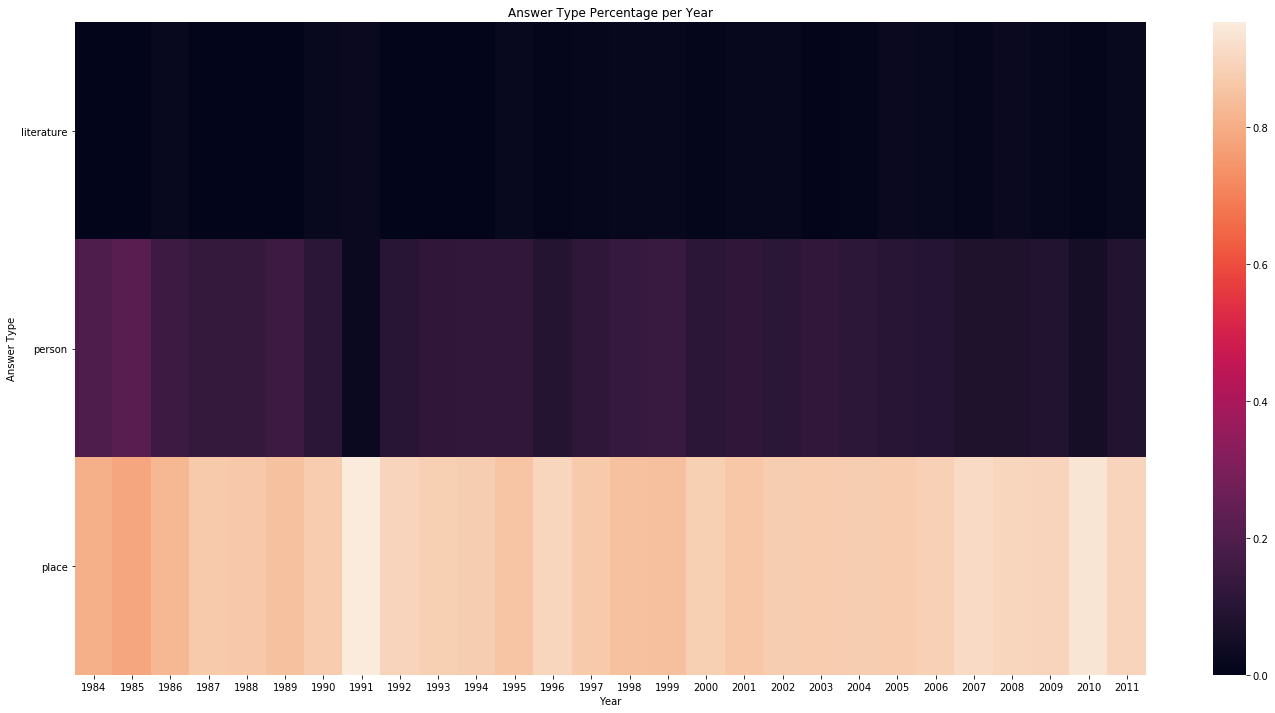

In [49]:
plt.figure(figsize=(24,12))
answerTypeHeat = sns.heatmap(answerTypesByYear, annot=False, fmt="f")

answerTypeHeat.set_xticklabels(range(minYear, maxYear+1))
answerTypeHeat.set_yticklabels(answerTypes, rotation=0)
answerTypeHeat.set_xlabel('Year')
answerTypeHeat.set_ylabel('Answer Type')
answerTypeHeat.set_title('Answer Type Percentage per Year')
plt.show()

## Rising Answer Types

In [50]:
placeIndex = answerTypes.index('place')
print("Percentage of Place answers in each year for the last 5 years")
placeLastFiveYears = answerTypesByYear[placeIndex][-5:]
for i in range(0, len(placeLastFiveYears)):
    print(str(2007+i) + ': ' + ('%.2f' % (placeLastFiveYears[i]*100)) + '%')


Percentage of Place answers in each year for the last 5 years
2007: 90.91%
2008: 90.00%
2009: 89.45%
2010: 93.72%
2011: 89.34%


In [51]:
risingAnswers = []
for i in range(0, len(answerTypesByYear)):
    typePercentByYear = answerTypesByYear[i]
    lastFiveYears = typePercentByYear[-5:]
    typeRiseFactor = (answerTypes[i], riseFactor(lastFiveYears))
    risingAnswers.append(typeRiseFactor)
    
risingAnswers.sort(key=lambda tup: tup[1], reverse=True)

for answer in risingAnswers:
    print(answer[0] + " rise factor:\t" + str(answer[1]))
    

person rise factor:	0.0056300361627064244
literature rise factor:	0.0010677226195791054
place rise factor:	-0.006697758782285535


## Consistent Answer Types

In [52]:
placeIndex = answerTypes.index('place')
years = [1984, 1989, 1994, 1999, 2004, 2009]
print("Percentage of History questions in different years")
placeByYears = answerTypesByYear[placeIndex]
for i in range(0, len(years)):
    print(str(years[i]) + ': ' + ('%.2f' % (placeByYears[years[i]-minYear]*100)) + '%')


Percentage of History questions in different years
1984: 80.56%
1989: 84.51%
1994: 87.50%
1999: 84.16%
2004: 87.76%
2009: 89.45%


In [53]:
def consistentFactor(means, typeIndex):
    consistency = 0.0
    typePercentages = answerTypesByYear[typeIndex]
    for i in range(0, len(means)):
        consistency += (typePercentages[i]-means[i])
    return consistency

In [54]:
consistencies = []
means = np.array(answerTypesByYear).mean(axis = 0)
for i in range(0, len(answerTypes)):
    consistency = (answerTypes[i], consistentFactor(means, i))
    consistencies.append(consistency)
    
consistencies.sort(key=lambda tup: tup[1], reverse=True)

for consistency in consistencies:
    print(consistency[0] + " consistent performance factor: " + str(consistency[1]))

place consistent performance factor: 15.1031042659
person consistent performance factor: -6.10017094484
literature consistent performance factor: -9.00293332104


## Answer Type Percentage Prediction
Now we will use linear regression to fit a model to our data.

In [55]:
dfAnswerTypesByYear.head()

,year,literature,person,place
0,1984,0.000000,0.194444,0.805556
1,1985,0.000000,0.217391,0.782609
2,1986,0.022222,0.155556,0.822222
3,1987,0.000000,0.130435,0.869565
4,1988,0.000000,0.133333,0.866667


In [56]:
typeModels = {}
for answerType in answerTypes:
    typeModels[answerType] = np.polyfit(dfAnswerTypesByYear['year'], dfAnswerTypesByYear[answerType], 1)

typeModels

{'literature': array([  5.38609202e-04,  -1.06407188e+00]),
 'person': array([ -2.88364827e-03,   5.87555750e+00]),
 'place': array([  2.34503907e-03,  -3.81148562e+00])}

In [57]:
def predictTypePercentage(answerType, year):
    a0 = typeModels[answerType][0]
    a1 = typeModels[answerType][1]
    predictedPercentage = (a0 * year) + a1
    return predictedPercentage

In [58]:
for answerType in answerTypes:
    print("Predictions for Subject: " + answerType)
    for year in nextFiveYears:
        print(str(year) + ":\t" + str(predictTypePercentage(answerType, year)*100) + "%")
        
    print()

Predictions for Subject: literature
2012:	1.96098338619%
2013:	2.01484430635%
2014:	2.0687052265%
2015:	2.12256614666%
2016:	2.17642706682%

Predictions for Subject: person
2012:	7.3657185422%
2013:	7.07735371543%
2014:	6.78898888866%
2015:	6.5006240619%
2016:	6.21225923513%

Predictions for Subject: place
2012:	90.6732980716%
2013:	90.9078019782%
2014:	91.1423058848%
2015:	91.3768097914%
2016:	91.611313698%



# Privacy/Ethics Considerations

The data we used raises little to no ethics or privacy considerations.

We had full permission to use the data as noted on the original Reddit thread, so long as we give the original poster credit and let them know of our project.

In terms of bias in collection of our data, there is a slight chronological bias to our data set. The person who collected the data had only about 85% of total questions at the time of their work. This meant that the dataset did not contain games from the last previous two years to the date of the original thread post. This could affect the data as any answers from those years will not be reflected in our observation. We hope this will be a minor issue as the game has had no major redesigns and the questions have not changed in wording nor relative difficulty.

In terms of privacy considerations, none of the data collected is linked personally to anyone. There are no names, birthdates, hometowns or any identifying points of data in the CSV file. However, the CSV files does include show air dates, which would mean that if a person were so inclined, they could figure out which people were on the show on a particular day. This is information that is already public on the Jeopardy Archive site.

# Conclusions and Discussion